# House Price Prediction Challenge
<h3> План  </h3>
 
* **Решение соревнования HousePricePrediction** 
 
* **Основные выводы** 

<img src='pics/housesbanner.png'>

Будем предсказывать цену дома по 79 признакам, описывающим его. Такая задача решалась в рамках соревнования на kaggle (соревнование все еще идет): https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import sklearn
import xgboost as xgb

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 4 base models for the stacking
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [2]:
train = pd.read_csv("../../../../data/train.csv")
test = pd.read_csv("../../../../data/test.csv")

labels = train.SalePrice

train.drop(["Id", "SalePrice"], axis=1, inplace=True)
test.drop(["Id"], axis=1, inplace=True)

In [3]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Краткое описание основных признаков:

- SalePrice — the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass — The building class
- MSZoning — The general zoning classification
- LotFrontage — Linear feet of street connected to property
- LotArea — Lot size in square feet
- Street — Type of road access
- Alley — Type of alley access
- LotShape — General shape of property
- LandContour — Flatness of the property
- Utilities — Type of utilities available
- LotConfig — Lot configuration

Что будем предсказывать?

In [5]:
labels.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

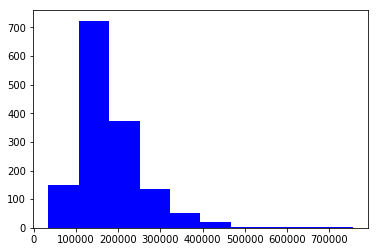

In [6]:
plt.hist(labels, color='blue')
plt.show()

Skew is: 0.12133506220520406


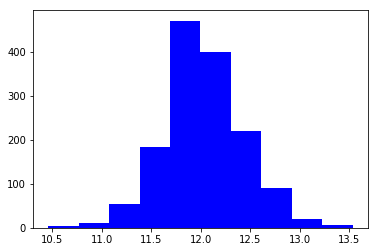

In [7]:
target = np.log(labels)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [9]:
all = pd.concat([train, test], axis=0)

Работа с пропусками в данных:

In [10]:
to_drop = ["MiscFeature", "PoolQC"]
to_replace_to_none = ["Fence", "FireplaceQu", "Alley"]

for col in to_replace_to_none:
    all[col].fillna("No" + col, inplace=True)
    
all.drop(to_drop, axis=1, inplace=True, errors="ignore")
all.fillna(-1, inplace=True)

Обработка категориальных признаков:

In [11]:
categorial = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "Fence", "SaleType", "SaleCondition"]
for col in categorial:
    all[col] = all[col].factorize()[0]
    
train = all.iloc[:train.shape[0]]
test = all.iloc[train.shape[0]:]

Кросс-валидация:

In [12]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, random_state=42)

Обучим RandomForest:

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=1000, max_depth=5, n_jobs=-1)
print(cross_val_score(regr, train, np.log1p(labels), scoring="mean_squared_error", cv=cv).mean())

/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yanina-n/miniconda3/envs/Clear_python3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


-0.027127960477707824


Можно сделать посылку в соревнование:

In [33]:
def submit(preds):
    submission = pd.read_csv("../../../../data/sample_submission.csv")
    submission["SalePrice"] = preds
    submission.to_csv("../../../../data/submission.csv", index=False)

regr = RandomForestRegressor(n_estimators=500, n_jobs=-1)
regr.fit(train, np.log1p(labels))
preds = regr.predict(test)
submit(np.expm1(preds))

In [34]:
!head ../../../../data/submission.csv

Id,SalePrice
1461,125515.96910055111
1462,154699.80388111714
1463,178396.78049304587
1464,181313.25028859603
1465,195726.27504195404
1466,182326.63780414345
1467,166453.32964329008
1468,173950.5399881651
1469,183073.03440644374


In [4]:
# Your code here